# Exploring Image Data 

# Completed by : Sanjay Kumar Dubey

* Overview of the dataset

- The data consists of MRI images. The data has four classes of images split into a training set and a testing set. These classes reflect the stages of dementia used by Health professionals when categorizing how far a person’s dementia or Alzheimer’s has progressed and they are as follows:

    1. Non Demented: No memory loss

    2. Very Mild Demented: Patient forgets names, misplaces familiar objects. Symptoms not evident to loved ones or doctors.

    3. Mild Demented: Increased forgetfulness affecting loved ones

    4. Moderate Demented: Physician can detect cognitive problems
         https://www.dementiacarecentral.com/aboutdementia/facts/stages/#:~:text=Very%20Mild%20Dementia%20%E2%80%93%20Memory%20problems%20are%20slight%2C,profound%20memory%20loss%2C%20only%20retaining%20highly%20learned%20material



- Due to the big size of the training dataset, it was decided to work only on the training set and divide it into 2 subsets a training and testing sub datasets

- Magnetic resonance imaging (MRI) is a medical imaging technique used in radiology to form pictures of the anatomy of the body. MRI scanners use strong magnetic fields to generate images of the organs in the body. A very common application of MRI is done on the brain to check for any brain damage.

In [2]:
from PIL import Image
import os
import numpy as np

dataset_path = 'dataset/Alzheimer'  # Replace with your actual dataset path

image_data = []  # List to store the image data
labels = []  # List to store the corresponding labels

# Iterate through the directories and subdirectories
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        image_path = os.path.join(root, file)
        
        try:
            # Attempt to open the file as an image
            image = Image.open(image_path)
            image_array = np.array(image)
            image_data.append(image_array)

            # Extract the label from the parent folder
            label = os.path.basename(os.path.dirname(image_path))
            labels.append(label)
        except (IOError, OSError):
            # Skip non-image files
            continue

# Convert the image data and labels lists to numpy arrays
image_data = np.array(image_data)
labels = np.array(labels)
classes = np.unique(labels)
# Flatten the image data
n_samples, h, w = image_data.shape
image_data_flattened = image_data.reshape((n_samples, h * w))
idx_to_reconstruct = 1

In [93]:
print(np.sum(~np.isfinite(image_data_flattened)))
print("n_samples: {}".format(n_samples))
print("n_features: {}".format(h*w))
print("n_classes: {}".format(classes))
print("Original Image Sizes {} by {}".format(h,w))
print (208*176) # the size of the images are the size of the feature vectors

0
n_samples: 6400
n_features: 36608
n_classes: ['MildDemented' 'ModerateDemented' 'NonDemented' 'VeryMildDemented']
Original Image Sizes 208 by 176
36608


So basically each feature vector is a giant image with the rows of the image just stacked one after the other into a giant vector. The image sizes are 208 pixels by 176 pixels. This gives us 208x176=36608 pixels per image.

So we are using each pixel location in the image as a separate feature.

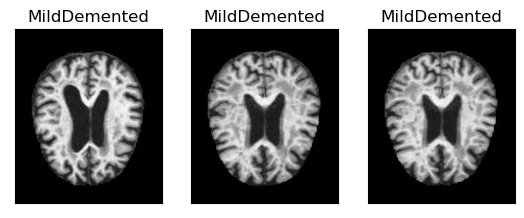

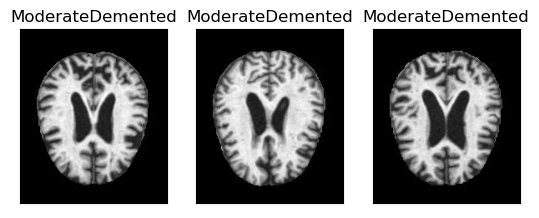

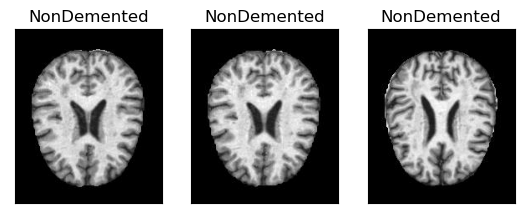

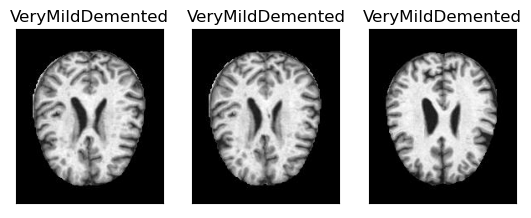

In [10]:
def plot_gallery(images, titles, h, w, n_row=1, n_col=3):
    """Helper function to plot a gallery of images"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

# Assuming you have multiple classes in your dataset
classes = np.unique(labels)  # Get unique class labels

# Plot images from each class
for class_label in classes:
    # Get the indices of images belonging to the current class
    class_indices = np.where(labels == class_label)[0]
    class_images = image_data[class_indices]
    class_labels = labels[class_indices]

    # Call the plotting function for each class
    plot_gallery(class_images, class_labels, h, w)

plt.show()


## Reconstruct Using Full PCA

Extracting the top 200 eigenfaces from 6400 images
CPU times: user 2min 19s, sys: 21.6 s, total: 2min 41s
Wall time: 26.8 s


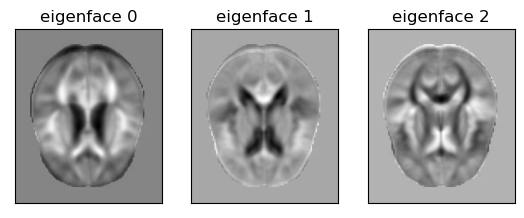

In [28]:
from sklearn.decomposition import PCA

n_components = 200
print("Extracting the top %d eigenfaces from %d images" % (n_components, image_data.shape[0]))

# Flatten the image data
n_samples, h, w = image_data.shape
image_data_flattened = image_data.reshape((n_samples, h * w))

# Perform PCA
pca = PCA(n_components=n_components)
%time pca.fit(image_data_flattened)

# Reshape eigenfaces back to 2D image format
eigenfaces = pca.components_.reshape((n_components, h, w))

# Visualize the eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)



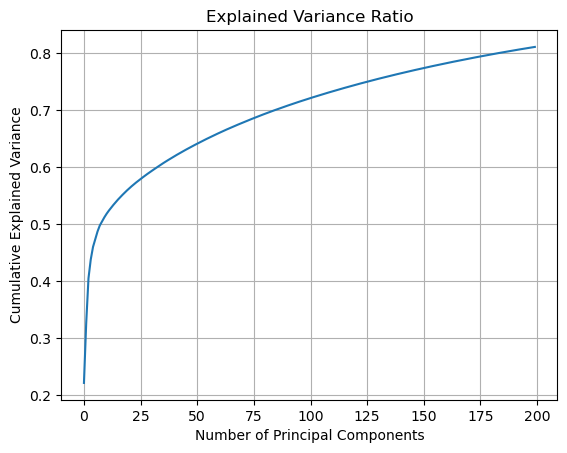

In [29]:
# Plot the explained variance ratio
def plot_explained_variance(pca):
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Principal Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Explained Variance Ratio')
    plt.grid(True)
    plt.show()

plot_explained_variance(pca)


In [31]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 1    
X_idx = image_data_flattened[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

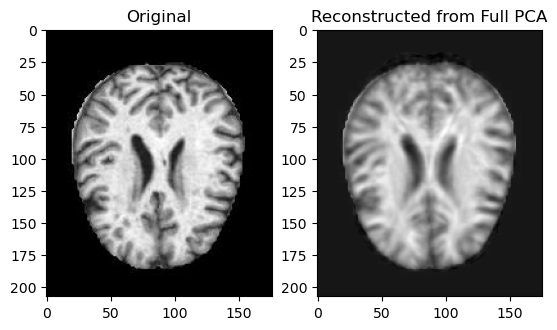

In [32]:
plt.subplot(1,2,1)
plt.imshow(X_idx.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
plt.subplot(1,2,2)
plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

## Randomized PCA

Of course, the methods that are used to calculate eigenvectors (the components) do not scale well with the number of features (in this case, the image dimensions). Recall that PCA works on the covariance matrix and the covariance matrix size is not affected by the number of examples, only the number of features. Randomized PCA helps to mitigate this by formulating the eigenvectors of a lower rank matrix using randomized projections.

More information here:

- http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- ftp://ftp.math.ucla.edu/pub/camreport/cam08-60.pdf
- Halko, et al., 2009 (arXiv:909) A randomized algorithm for the decomposition of matrices Per-Gunnar Martinsson, Vladimir Rokhlin and Mark Tygert

Extracting the top 300 eigenfaces from 6400 images
CPU times: user 3min 35s, sys: 53.6 s, total: 4min 29s
Wall time: 43.1 s


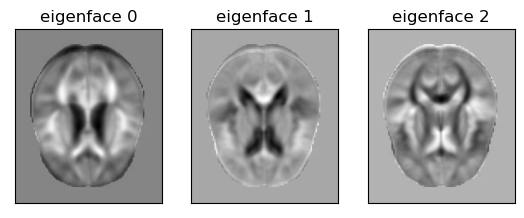

In [36]:
from sklearn.decomposition import PCA

n_components = 300
print("Extracting the top %d eigenfaces from %d images" % (n_components, image_data_flattened.shape[0]))

# Perform Randomized PCA
rpca = PCA(n_components=n_components, svd_solver='randomized')
%time rpca.fit(image_data_flattened)

# Reshape eigenfaces back to 2D image format
eigenfaces = rpca.components_.reshape((n_components, h, w))

# Visualize the eigenfaces
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)


In [39]:
#conda install -c anaconda ipywidgets

In [49]:
# widgets example
from ipywidgets import widgets  # make this interactive!

widgets.interact(lambda x: print(x),x=(0,5,1))

2


<function __main__.<lambda>(x)>

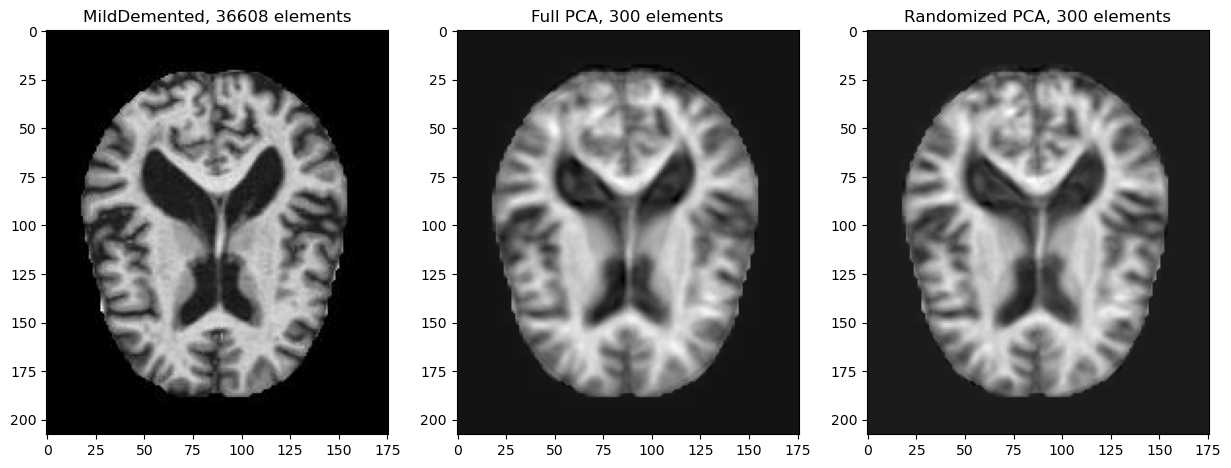

<function __main__.plt_reconstruct(idx_to_reconstruct)>

In [52]:
def plt_reconstruct(idx_to_reconstruct):
    # this code is for reference only, it does not qualify as a nearest neighbor search
    # for your lab project.
    idx_to_reconstruct = np.round(idx_to_reconstruct)

    x_flat = image_data_flattened[idx_to_reconstruct].reshape(1, -1)
    reconstructed_image = pca.inverse_transform(pca.transform(x_flat.copy()))
    reconstructed_image_rpca = rpca.inverse_transform(rpca.transform(x_flat.copy()))

    plt.figure(figsize=(15, 7))

    plt.subplot(1, 3, 1)  # original
    plt.imshow(image_data[idx_to_reconstruct].reshape((h, w)), cmap=plt.cm.gray)
    plt.title(labels[idx_to_reconstruct] + f", {x_flat.shape[1]} elements")
    plt.grid(False)

    plt.subplot(1, 3, 2)  # pca
    plt.imshow(reconstructed_image.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(f"Full PCA, {n_components} elements")
    plt.grid(False)

    plt.subplot(1, 3, 3)  # randomized pca
    plt.imshow(reconstructed_image_rpca.reshape((h, w)), cmap=plt.cm.gray)
    plt.title(f"Randomized PCA, {n_components} elements")
    plt.grid(False)


widgets.interact(plt_reconstruct, idx_to_reconstruct=(0, n_samples - 1, 1), __manual=True)


## PCA For Image Classification

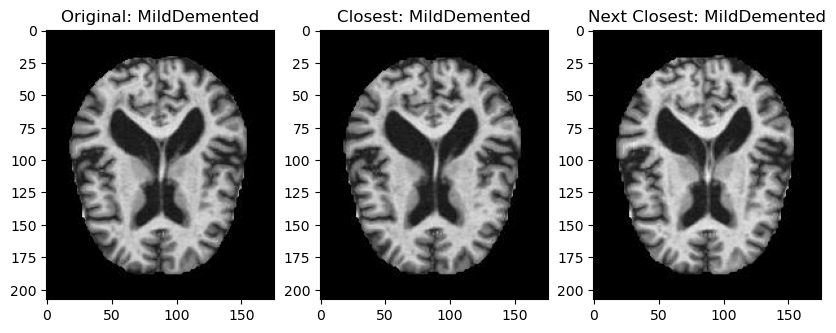

<function __main__.closest_image(dmat_pca, idx1)>

In [58]:
from ipywidgets import fixed
import copy

from sklearn.metrics.pairwise import pairwise_distances

X_pca_features = pca.transform(copy.deepcopy(image_data_flattened))
dist_matrix_pca = pairwise_distances(copy.deepcopy(X_pca_features), metric="seuclidean")

def closest_image(dmat_pca, idx1):
    distances = copy.deepcopy(dmat_pca[idx1, :])  # Get all image distances
    distances[idx1] = np.infty  # Don't pick the same image!
    idx2 = np.argmin(distances)  # pca

    distances[idx2] = np.infty  # Don't pick the same image!
    idx3 = np.argmin(distances)  # pixels

    plt.figure(figsize=(10, 16))
    plt.subplot(1, 3, 1)
    plt.imshow(image_data[idx1], cmap=plt.cm.gray)
    plt.title("Original: " + labels[idx1])
    plt.grid(False)

    plt.subplot(1, 3, 2)
    plt.imshow(image_data[idx2], cmap=plt.cm.gray)
    plt.title("Closest: " + labels[idx2])
    plt.grid(False)

    plt.subplot(1, 3, 3)
    plt.imshow(image_data[idx3], cmap=plt.cm.gray)
    plt.title("Next Closest: " + labels[idx3])
    plt.grid(False)

widgets.interact(closest_image, idx1=(0, n_samples - 1, 1), dmat_pca=fixed(dist_matrix_pca), __manual=True)


In [62]:
#conda install -c anaconda scikit-image

# Image Processing

Now let's look at other Methods for extracting features from images.



Let's start by calculating gradients:

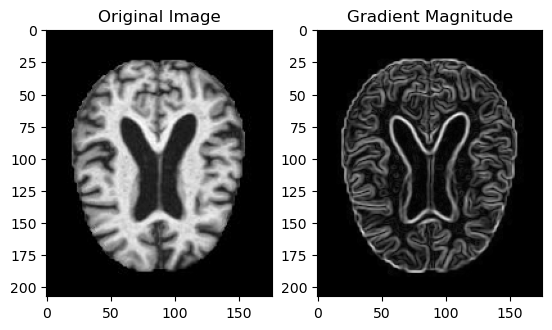

In [61]:
from skimage.filters import sobel_h, sobel_v

plt.subplot(1, 2, 1)
idx_to_reconstruct = int(np.random.rand(1) * len(image_data))
img = image_data[idx_to_reconstruct].reshape((h, w))
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.grid(False)

plt.subplot(1, 2, 2)
gradient_mag = np.sqrt(sobel_v(img) ** 2 + sobel_h(img) ** 2)
plt.imshow(gradient_mag, cmap='gray')
plt.title('Gradient Magnitude')
plt.grid(False)

plt.show()


## Image Feature: DAISY Bag of Features Model



 DAISY Features are a means of looking at histograms of edges weights using gradients at various orientations.

http://scikit-image.org/docs/dev/_images/sphx_glr_plot_daisy_001.png

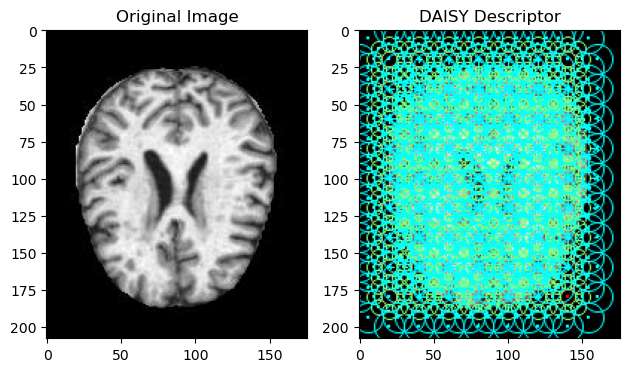

In [63]:
from skimage.feature import daisy

# Select an image from your dataset
idx = 0  # Replace with the index of the image you want to use
img = image_data[idx].reshape((h, w))

# Compute the DAISY descriptor
step = 20
radius = 20
rings = 2
histograms = 8
orientations = 8
features, img_desc = daisy(img, step=step, radius=radius, rings=rings,
                           histograms=histograms, orientations=orientations, visualize=True)

# Display the DAISY descriptor
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(img_desc, cmap='gray')
plt.title('DAISY Descriptor')
plt.grid(False)

plt.tight_layout()
plt.show()


In [64]:
n, m, d = features.shape
total_features = n * m * d
print(total_features)

8568


In [65]:
# now let's understand how to use it
features = daisy(img, step=20, radius=20, rings=2, histograms=8, orientations=4, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(9, 7, 68)
4284


In [73]:
# Create a function to apply the DAISY descriptor to a single image
def apply_daisy(row, shape):
    feat = daisy(row.reshape(shape), step=20, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(image_data[3],(h,w))
test_feature.shape

CPU times: user 29 ms, sys: 5.94 ms, total: 34.9 ms
Wall time: 32.7 ms


(4284,)

In [77]:
# create a function to take in the row of the matrix and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape), step=20, radius=20, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(image_data[3],(h,w))
test_feature.shape
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, image_data_flattened, (h,w))
print(daisy_features.shape)
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 31.5 ms, sys: 5.68 ms, total: 37.2 ms
Wall time: 39.6 ms


(4284,)

In [79]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, image_data_flattened, (h,w))
print(daisy_features.shape)

CPU times: user 1min 49s, sys: 566 ms, total: 1min 49s
Wall time: 1min 49s
(6400, 4284)


In [80]:
from sklearn.metrics.pairwise import pairwise_distances
# find the pairwise distance between all the different image features
%time dist_matrix = pairwise_distances(daisy_features)

CPU times: user 14.7 s, sys: 2.19 s, total: 16.9 s
Wall time: 2.33 s


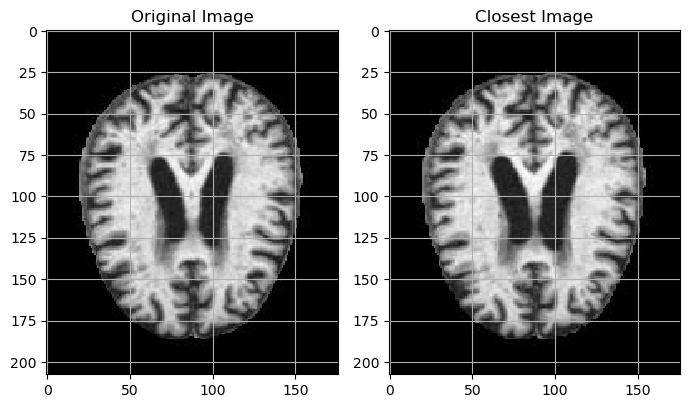

In [83]:
import copy
from skimage.io import imshow
from skimage.filters import sobel_h, sobel_v
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(image_data_flattened[idx1].reshape((h,w)))
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(image_data_flattened[idx2].reshape((h,w)))
plt.title("Closest Image")
plt.grid()

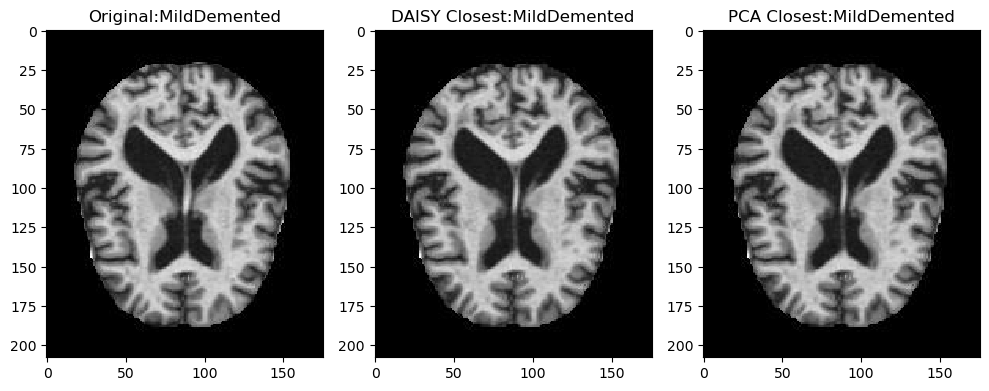

<function __main__.closest_image(dmat_daisy, dmat_pca, idx1)>

In [84]:
from ipywidgets import fixed
import copy
from skimage.io import imshow

# Put it together inside a nice widget
def closest_image(dmat_daisy, dmat_pca, idx1):
    distances = copy.deepcopy(dmat_daisy[idx1, :])  # Get all image distances
    distances[idx1] = np.infty  # Don't pick the same image!
    idx2 = np.argmin(distances)

    distances = copy.deepcopy(dmat_pca[idx1, :])  # Get all image distances
    distances[idx1] = np.infty  # Don't pick the same image!
    idx3 = np.argmin(distances)

    plt.figure(figsize=(10, 16))
    plt.subplot(1, 3, 1)
    imshow(image_data[idx1].reshape((h, w)))
    plt.title("Original:" + labels[idx1])
    plt.grid(False)

    plt.subplot(1, 3, 2)
    imshow(image_data[idx2].reshape((h, w)))
    plt.title("DAISY Closest:" + labels[idx2])
    plt.grid(False)

    plt.subplot(1, 3, 3)
    imshow(image_data[idx3].reshape((h, w)))
    plt.title("PCA Closest:" + labels[idx3])
    plt.grid(False)

# Execute the widget code after computing the distance matrices
widgets.interact(closest_image, idx1=(0, n_samples - 1, 1),
                 dmat_daisy=fixed(dist_matrix),
                 dmat_pca=fixed(dist_matrix_pca),
                 __manual=True)


## K-Nearest Neighbor Classification with each Feature Space

Let's try getting a more quantitative measure of performance by using a sklearn classifier for each feature space.

In [86]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Initialize a classifier for each feature space
knn_pca = KNeighborsClassifier(n_neighbors=1)
knn_dsy = KNeighborsClassifier(n_neighbors=1)

# Separate the data into train/test
pca_train, pca_test, dsy_train, dsy_test, y_train, y_test = train_test_split(
    X_pca_features, daisy_features, labels, test_size=0.2, train_size=0.8)

# Fit each classifier
knn_pca.fit(pca_train, y_train)
acc_pca = accuracy_score(knn_pca.predict(pca_test), y_test)

knn_dsy.fit(dsy_train, y_train)
acc_dsy = accuracy_score(knn_dsy.predict(dsy_test), y_test)

# Report accuracy
print(f"PCA accuracy: {100*acc_pca:.2f}%, DAISY accuracy: {100*acc_dsy:.2f}%")


PCA accuracy: 99.69%, DAISY accuracy: 99.92%


In [87]:
# for the exceptional credit, you might be interested in the following code
# you will need to repeat this for all pairs of images in the testing and training 
from skimage.feature import match_descriptors

def apply_daisy(row,shape): # no reshape in this function
    feat = daisy(row.reshape(shape), step=5, radius=5, 
                 rings=2, histograms=8, orientations=4, 
                 visualize=False)
    s = feat.shape # PxQxR
    #P = ceil((Height - radius*2) / step) 
    #Q = ceil((Width - radius*2) / step) 
    #R = (rings * histograms + 1) * orientations
    return feat.reshape((s[0]*s[1],s[2]))

d1 = apply_daisy(image_data_flattened[10],(h,w))
d2 = apply_daisy(image_data_flattened[11],(h,w))
d3 = apply_daisy(image_data_flattened[0],(h,w))

print(d1.shape, d2.shape, d3.shape)
print('Classes:',y[10],y[11],y[0])

# return list of the key points indices that matched closely enough
matches = match_descriptors(d1, d2, cross_check=True, max_ratio=0.8)
print(f"Number of matches, same class: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

# return list of the key points indices that matched closely enough
matches = match_descriptors(d1, d3, cross_check=True, max_ratio=0.8)
print(f"Number of matches, diff classes: {matches.shape[0]}, Percentage:{100*matches.shape[0]/len(d1):0.2f}%")

(1360, 68) (1360, 68) (1360, 68)
Classes: VeryMildDemented VeryMildDemented VeryMildDemented
Number of matches, same class: 188, Percentage:13.82%
Number of matches, diff classes: 220, Percentage:16.18%


## Gabor Kernels for Feature Extraction 

In [89]:
from skimage.filters import gabor_kernel
from scipy import ndimage as ndi
from scipy import stats

# prepare filter bank kernels
kernels = []
for theta in range(8):# orientations
    theta = theta / 8. * np.pi
    for sigma in (1, 3, 5): # std
        for frequency in (0.05, 0.15, 0.25, 0.35): # frequency
            kernel = np.real(gabor_kernel(frequency, theta=theta,
                                          sigma_x=sigma, sigma_y=sigma))
            kernels.append(kernel)

            
# compute the filter bank and take statistics of image
# this can be drastically sped up using the 2D FFT
def compute_gabor(row, kernels, shape):
    feats = np.zeros((len(kernels), 4), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = ndi.convolve(row.reshape(shape), kernel, mode='wrap')
        _,_,feats[k,0],feats[k,1],feats[k,2],feats[k,3] = stats.describe(filtered.reshape(-1))
        # mean, var, skew, kurt
        
    return feats.reshape(-1)

idx_to_reconstruct = int(np.random.rand(1)*len(image_data_flattened))

gabr_feature = compute_gabor(image_data_flattened[idx_to_reconstruct], kernels, (h,w))
gabr_feature.shape

(384,)

In [91]:
# takes some time to run entire dataset (using lots of orientations, std, and frequency)
%time gabor_stats = np.apply_along_axis(compute_gabor, 1, image_data_flattened, kernels, (h,w))
print(gabor_stats.shape)

In [ ]:
knn_gab = KNeighborsClassifier(n_neighbors=1)

gab_train, gab_test, y_train, y_test = train_test_split(
    gabor_stats,y,test_size=0.2, train_size=0.8)
knn_gab.fit(gab_train,y_train)
acc_gab = accuracy_score(knn_gab.predict(gab_test),y_test)

print(f"Gabor accuracy: {100*acc_gab:.2f}%"

### In this notebook you learned:

- Principle Components Analisys
- Randomized PCA
- Image Features (like Daisy)
- Classifying Images with Nearest Neighbor Distance
- Using both quantitative and qualitative methods
- Matching techniques
- Gabor Filters as a Feature

                                        Thank You